In [1]:
import os
import sys

import pandas as pd
import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils
from torchvision.utils import save_image, make_grid

import cv2 

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
IMAGES_DIR = 'edge_detection_results'
os.makedirs(IMAGES_DIR, exist_ok=True)

# Изучение работы алгоритма Canny edge detection

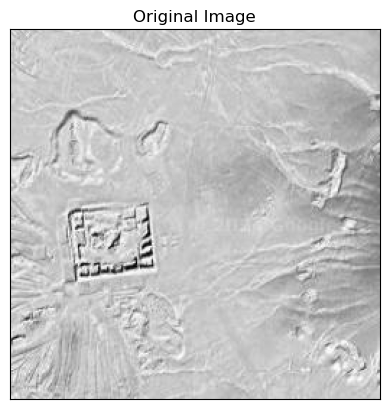

In [3]:
img = cv2.imread('../sample_data/positive_samples/000000.jpeg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show()

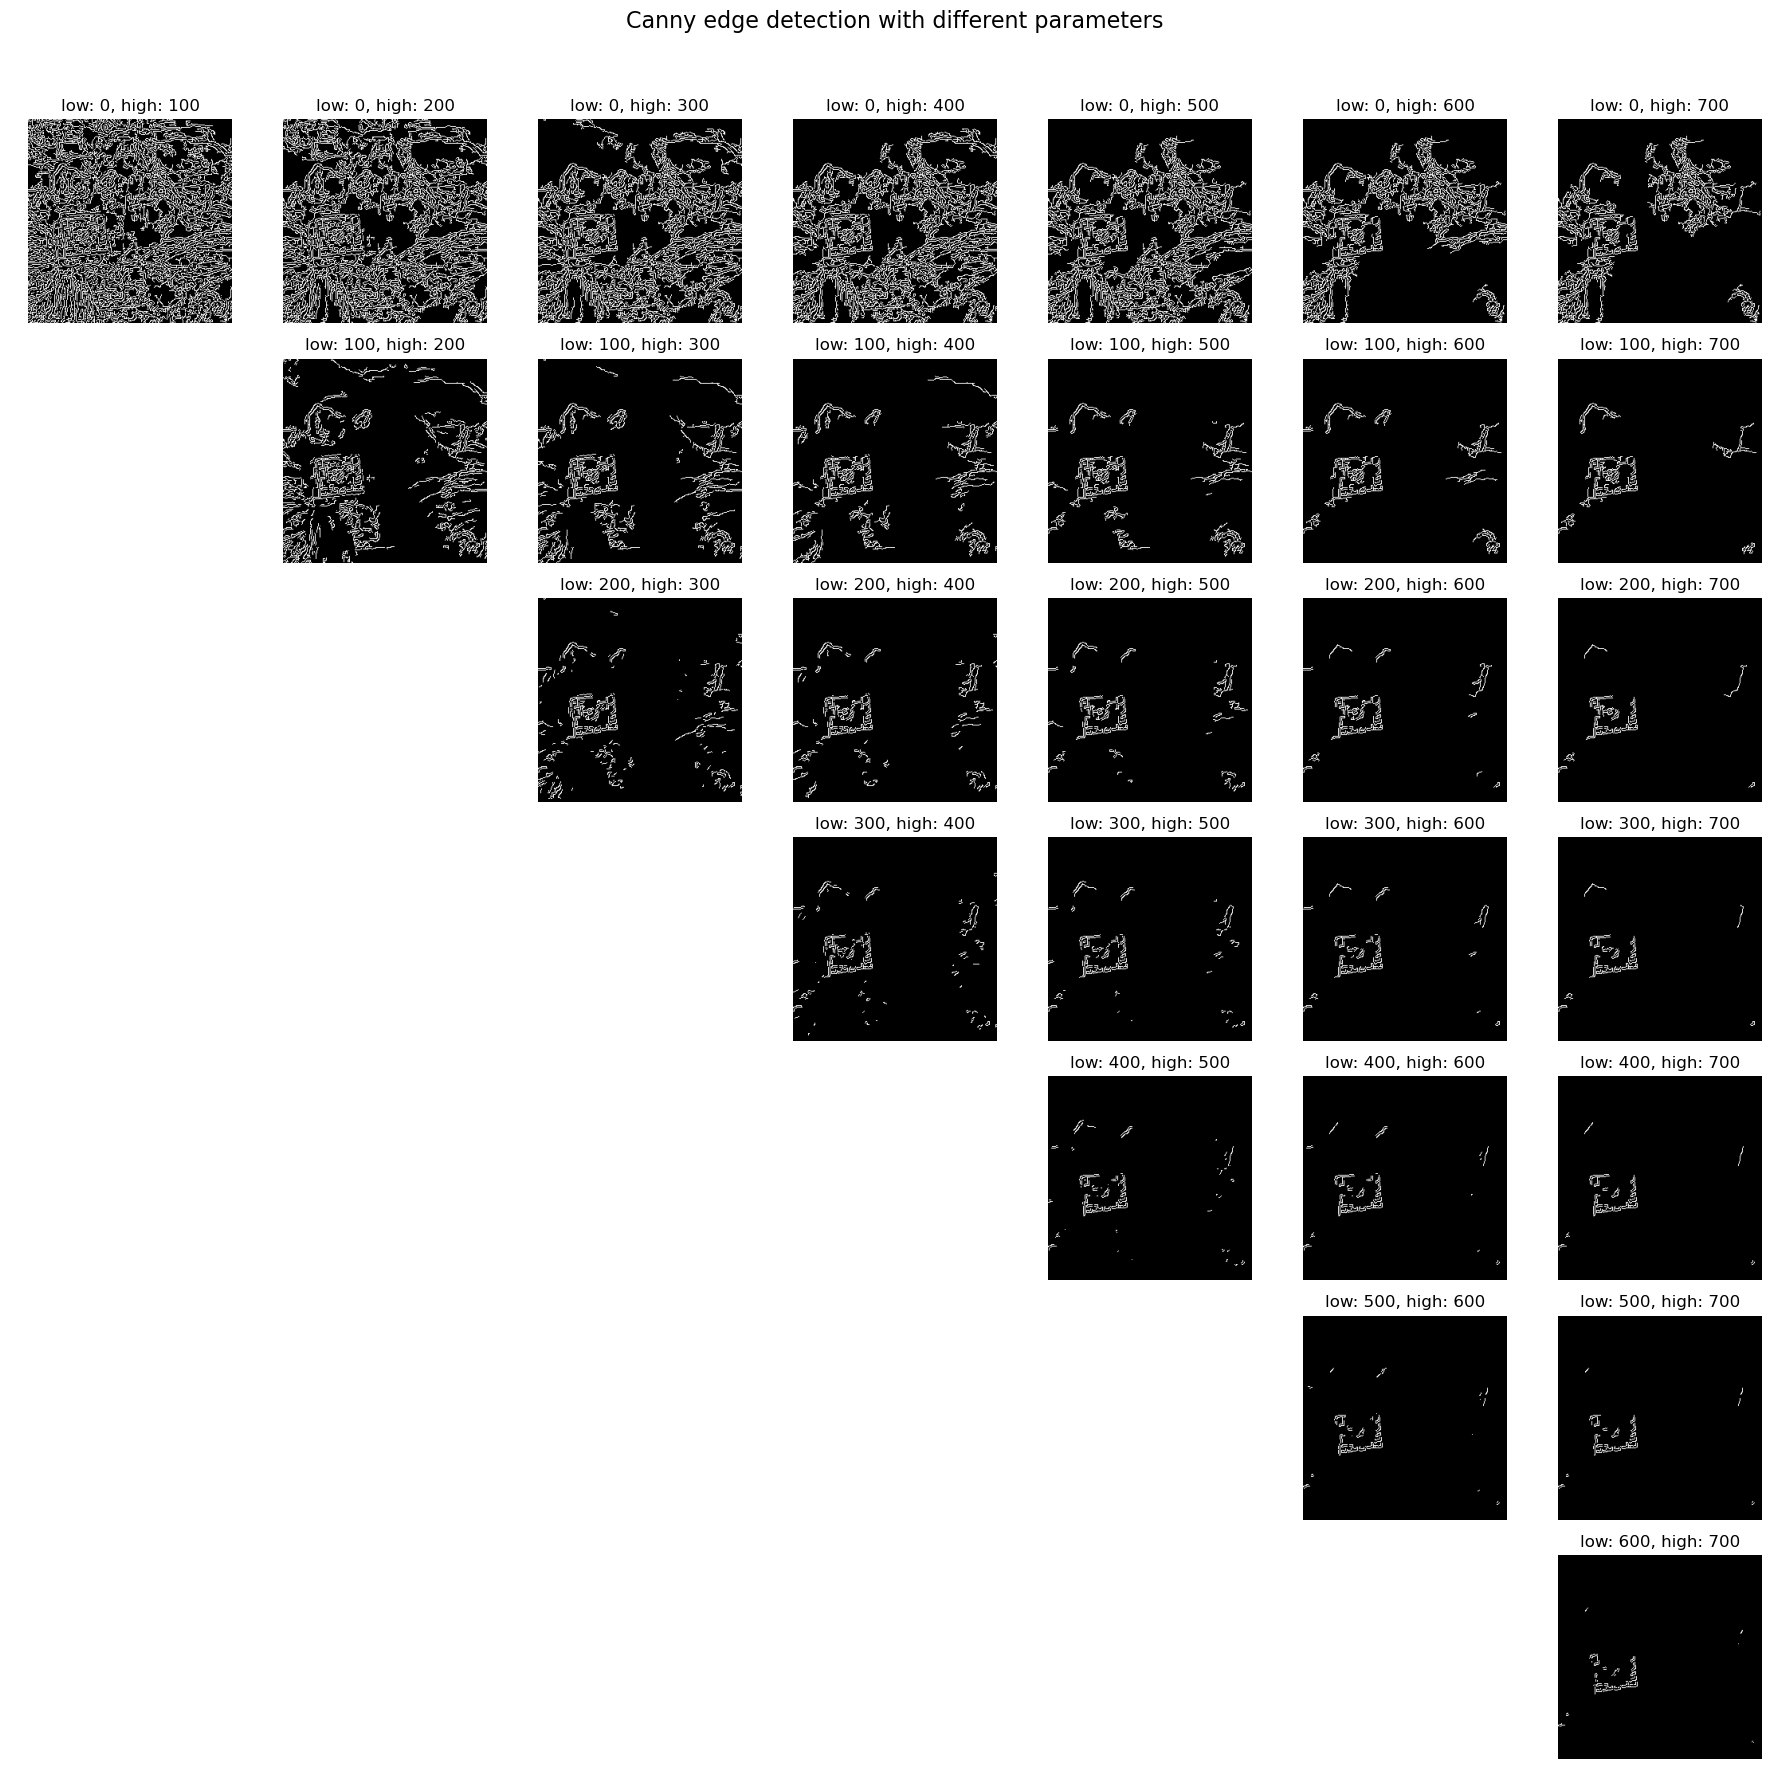

In [4]:
fig, axes = plt.subplots(7, 7, figsize=(18, 18))
img = cv2.imread('../sample_data/positive_samples/000000.jpeg', cv2.IMREAD_GRAYSCALE)

for i, low_threshold in enumerate(range(0, 700, 100)):
    for j, high_threshold in enumerate(range(100, 800, 100)):
        axes[i, j].axis('off')
        if low_threshold < high_threshold:
            edges = cv2.Canny(img, low_threshold, high_threshold)  
            axes[i, j].imshow(edges, cmap='gray')
            axes[i, j].set_title(f'low: {low_threshold}, high: {high_threshold}')
            
plt.suptitle('Canny edge detection with different parameters', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'{IMAGES_DIR}/canny_parameters')

In [5]:
def plot_canny(low, high, anomailes=True, n_imgs=6, save=False):
    fig, axes = plt.subplots(2, n_imgs, figsize=(n_imgs * 3, 2 * 3))
    for i in range(n_imgs):
        if anomailes:
            img_path = f'../sample_data/positive_samples/{i:06}.jpeg'
        else:
            img_path = f'../sample_data/negative_samples/{i:06}.jpeg'
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        edges = cv2.Canny(img, low, high)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Original {i}')
        axes[0, i].axis('off')
        axes[1, i].imshow(edges, cmap='gray')
        axes[1, i].set_title(f'Edges {i}')
        axes[1, i].axis('off')
    plt.suptitle(f'Canny {anomailes=} ({low=}, {high=})')
    plt.tight_layout()
    if save:
        plt.savefig(save)

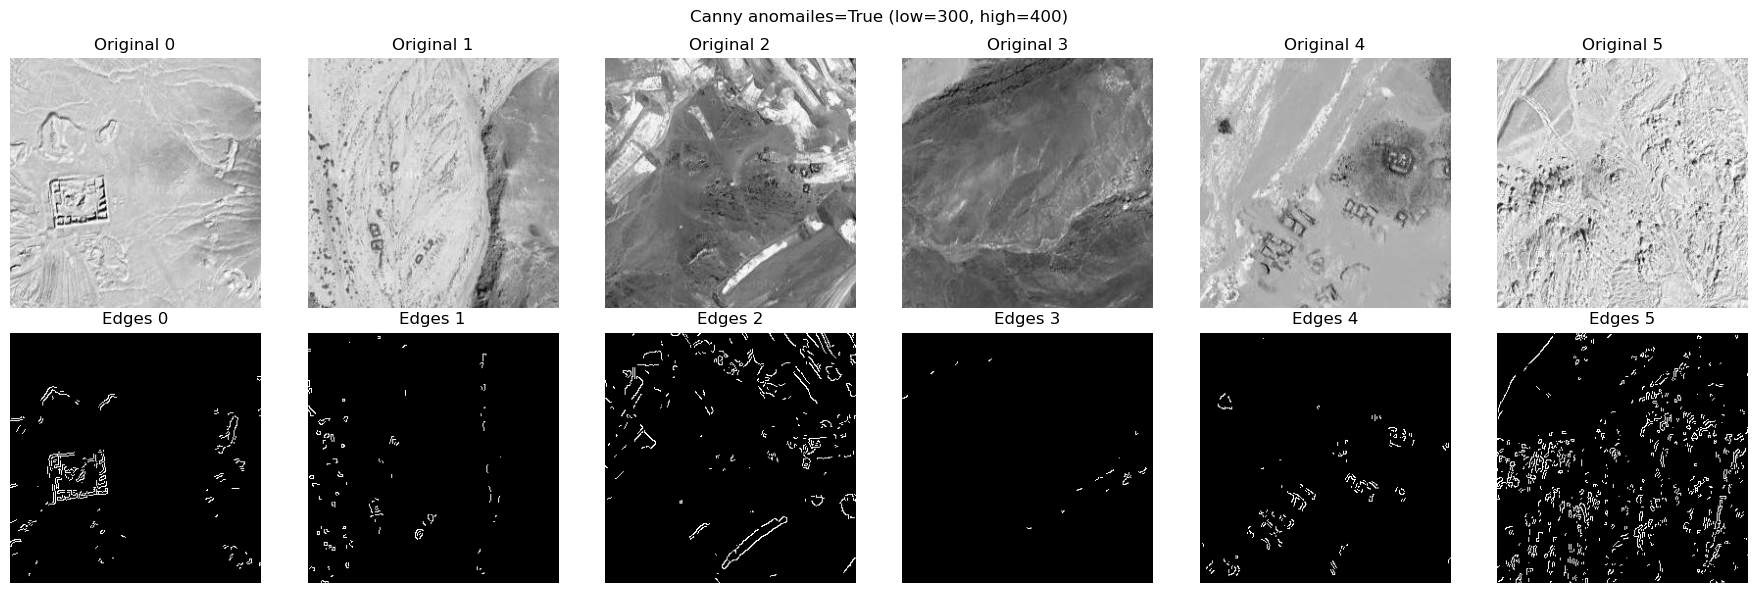

In [6]:
plot_canny(300, 400, anomailes=True, n_imgs=6, save=f'{IMAGES_DIR}/postivie_samples_canny_edges')

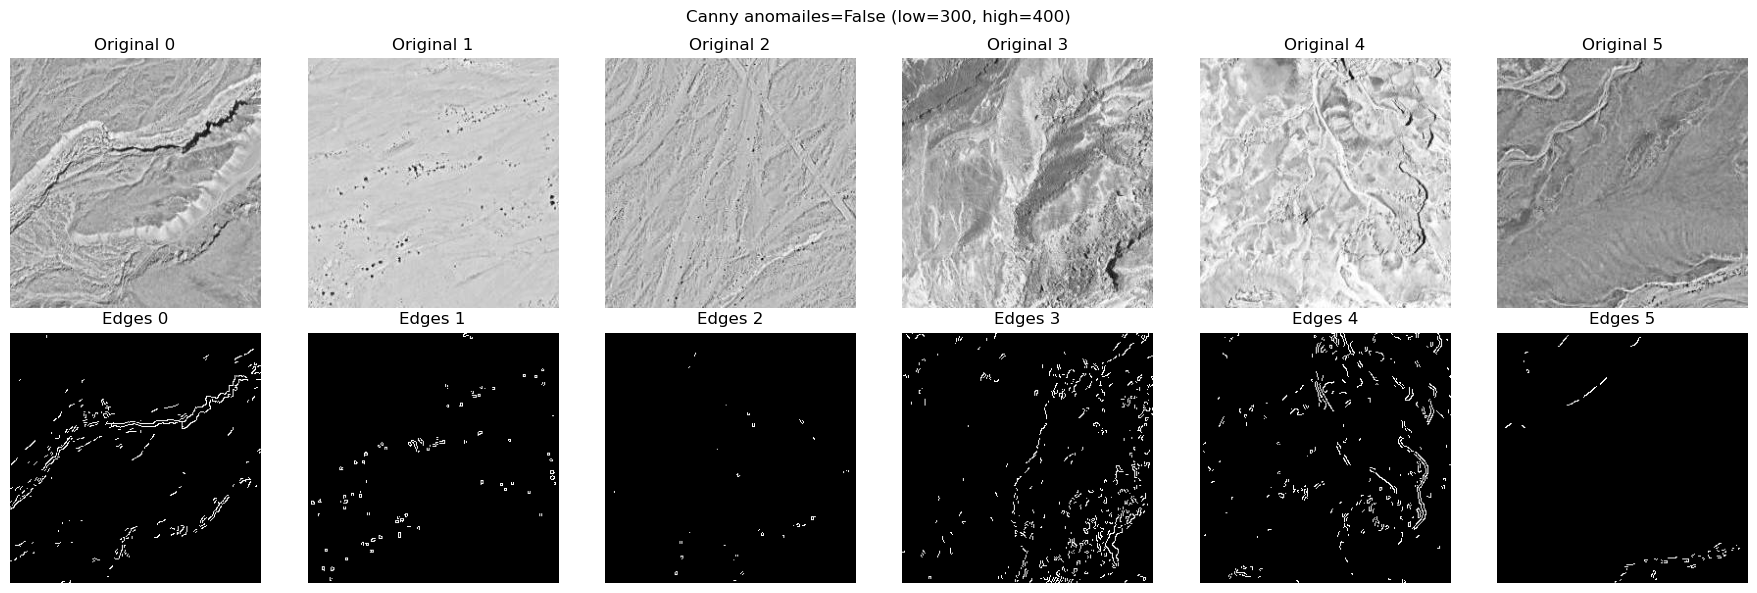

In [7]:
plot_canny(300, 400, anomailes=False, n_imgs=6, save=f'{IMAGES_DIR}/negative_samples_canny_edges')

# Применяем Canny к разнице между исходной картинкой и пропущенной через VAE

In [8]:
from model import VQVAE

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

params = {
    'batch_size': 1024,
    'img_size': 256,
    'channels': 1,
    'embedding_dim': 8,
    'num_embeddings': 8,
    'beta': 0.25,
    'n_epochs': 15,
}

model = VQVAE(
    in_channels=params['channels'],
    img_size=params['img_size'],
    
    embedding_dim=params['embedding_dim'],
    num_embeddings=params['num_embeddings'],
    beta=params['beta']
)

device = 'cpu'
model.to(device)
model.load_state_dict(torch.load('../vq_vae_training_sasgis_results/v2_256pix_gray_08embdim_08embeds/checkpoint_9.pth', map_location=device))

<All keys matched successfully>

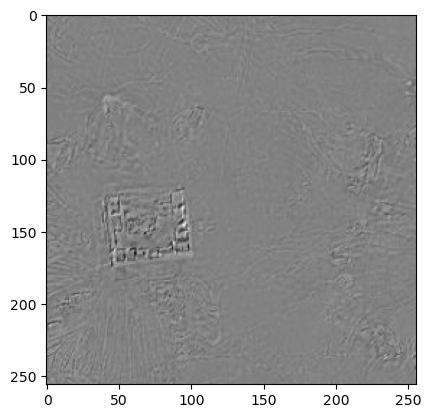

In [9]:
img = Image.open('../sample_data/positive_samples/000000.jpeg')
res = model(transform(img)[None, :])
diff = transform(img) - res[0][0].detach().numpy()
plt.imshow(diff.permute(1, 2, 0), cmap='gray');

In [10]:
transformed_diff = diff.numpy()
transformed_diff = 255.0 * (transformed_diff - transformed_diff.min()) / (transformed_diff.max() - transformed_diff.min())
transformed_diff = np.array(transformed_diff, dtype=np.uint8)
transformed_diff = transformed_diff.transpose(1, 2, 0)

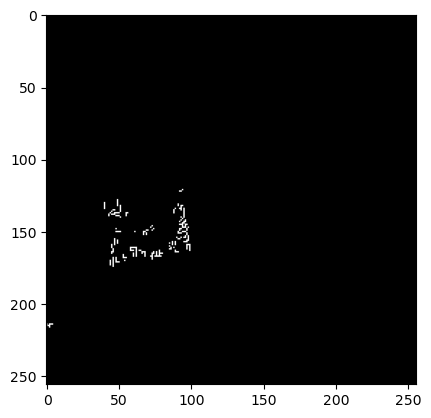

In [11]:
plt.imshow(cv2.Canny(transformed_diff, 300, 400), cmap='gray');

In [12]:
def apply_canny_to_diff(img):
    res = model(transform(img)[None, :])
    diff = transform(img) - res[0][0].detach().numpy()
    transformed_diff = diff.numpy()
    transformed_diff = 255.0 * (transformed_diff - transformed_diff.min()) / (transformed_diff.max() - transformed_diff.min())
    transformed_diff = np.array(transformed_diff, dtype=np.uint8)
    transformed_diff = transformed_diff.transpose(1, 2, 0)
    return cv2.Canny(transformed_diff, 300, 400)

In [13]:
def plot_canny_to_diff(anomailes=True, n_imgs=6, save=False):
    fig, axes = plt.subplots(2, n_imgs, figsize=(n_imgs * 3, 2 * 3))
    for i in range(n_imgs):
        if anomailes:
            img_path = f'../sample_data/positive_samples/{i:06}.jpeg'
        else:
            img_path = f'../sample_data/negative_samples/{i:06}.jpeg'
        img = Image.open(img_path)
        canny_res = apply_canny_to_diff(img)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Original {i}')
        axes[0, i].axis('off')
        axes[1, i].imshow(canny_res, cmap='gray')
        axes[1, i].set_title(f'Canny applied to diff {i}')
        axes[1, i].axis('off')
    plt.suptitle(f'Canny applied to diff ({anomailes=})')
    plt.tight_layout()
    if save:
        plt.savefig(save)

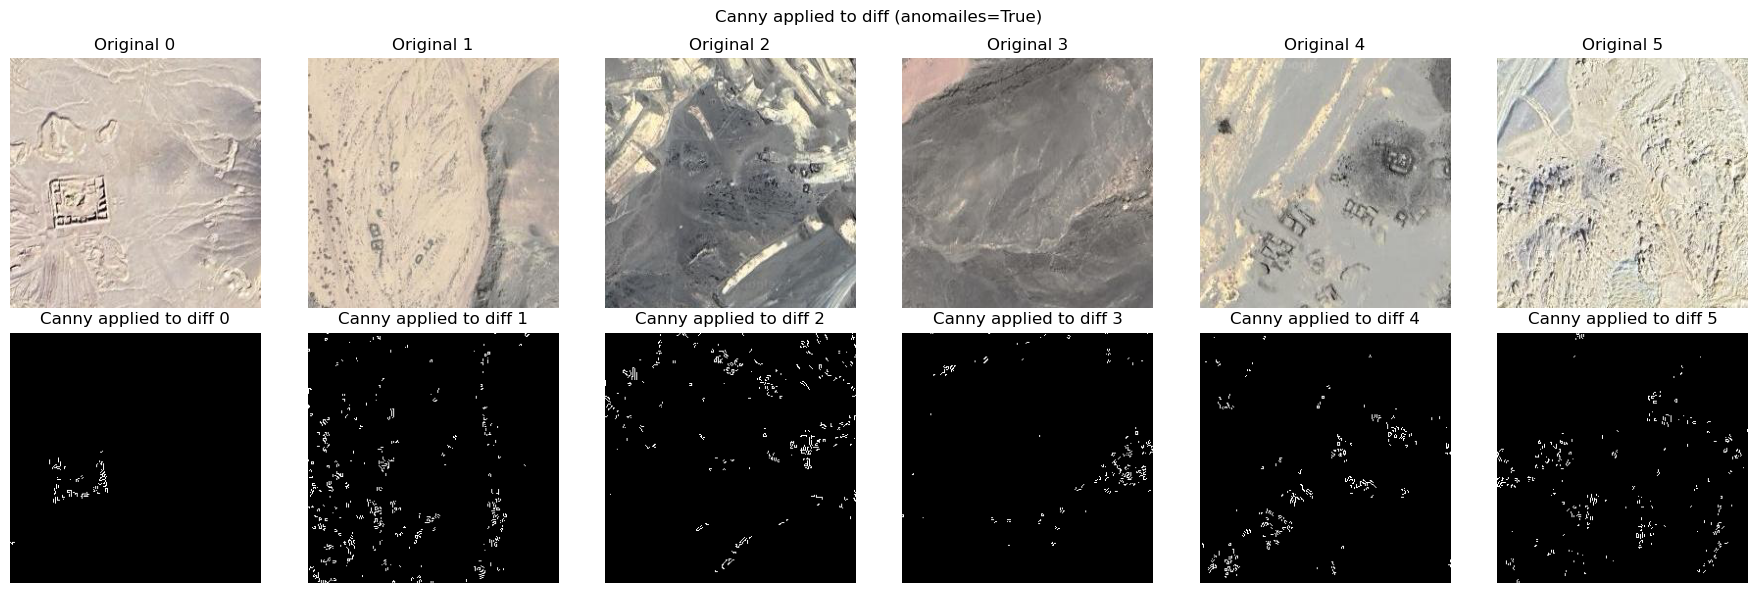

In [14]:
plot_canny_to_diff(anomailes=True, n_imgs=6, save=f'{IMAGES_DIR}/positive_samples_canny_to_diff')

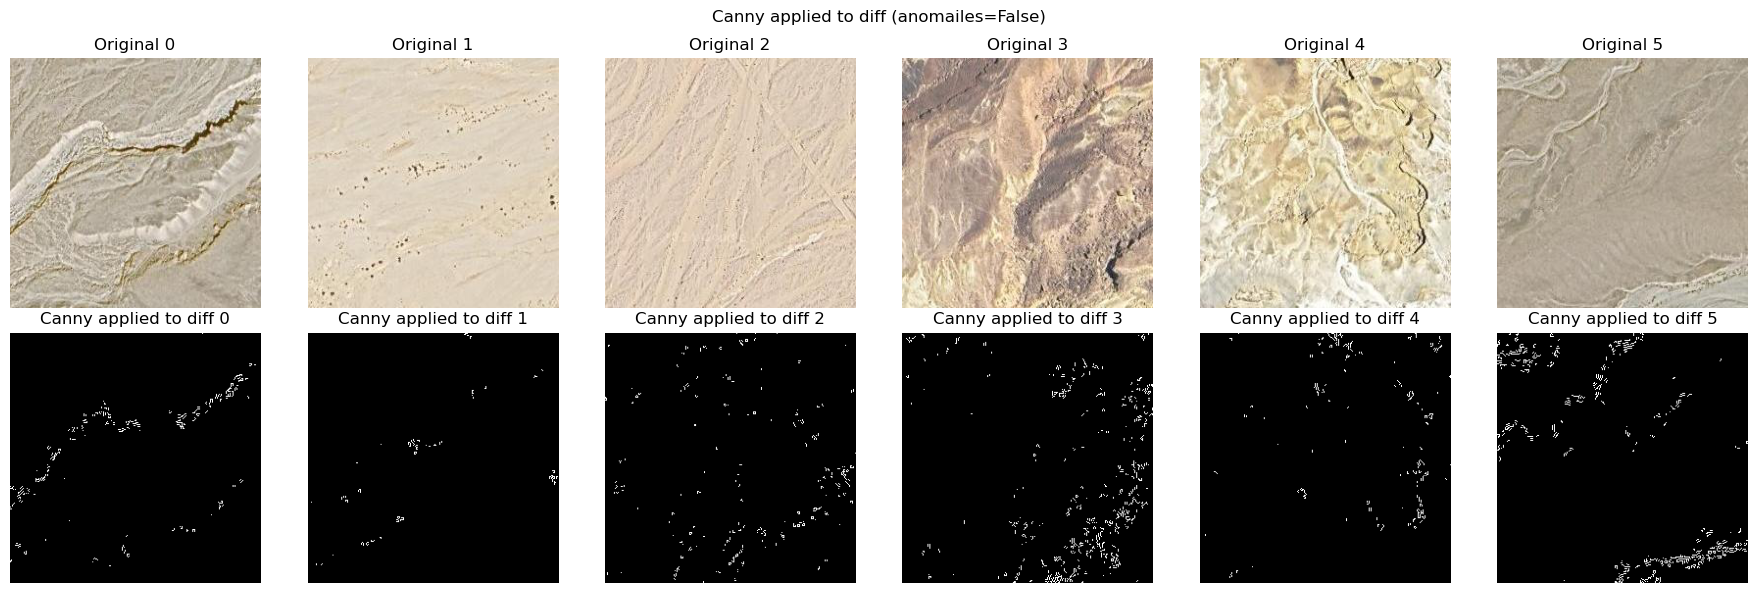

In [15]:
plot_canny_to_diff(anomailes=False, n_imgs=6, save=f'{IMAGES_DIR}/negative_samples_canny_to_diff')